# Counterfactual Data Substitution (CDS)

In [1]:
# set cwd
import os
os.chdir("g:\\My Drive\\ITC, 5th semester (Thesis)\\Code\\Github_code\\toxicity_detection")

# imports
import pandas as pd
import random
from collections import Counter
import matplotlib.pyplot as plt
from string import punctuation
import spacy
from spacy import displacy
from tqdm import tqdm
from utils import load_dkhate
from typing import Dict

In [2]:
# load gender triplet dictionary from excel-file
gender_df = pd.read_excel(os.getcwd()+"\\mitigation\\gender_triplet_dict.xlsx")
gender_dict = gender_df.T.to_dict()

# inspect format
for i in range(5):
    print(gender_dict[i])

{'female': 'abbedisse', 'male': 'abbed', 'queer': 'KtM'}
{'female': 'abbedisser', 'male': 'abbeder', 'queer': "KtM'er"}
{'female': 'baronesse', 'male': 'baron', 'queer': 'MtK'}
{'female': 'baronesser', 'male': 'baroner', 'queer': "MtK'er"}
{'female': 'bedstemor', 'male': 'bedstefar', 'queer': 'demi person'}


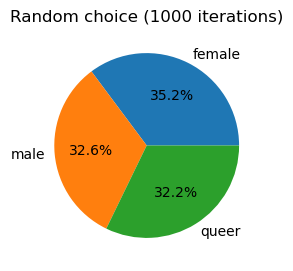

In [3]:
# check randomness of random.choice
storage = [random.choice(["female", "male", "queer"]) for i in range(1000)]

plt.figure(figsize=(3,3))
plt.pie(dict(Counter(storage)).values(), labels=dict(Counter(storage)).keys(), autopct='%1.1f%%')
plt.title("Random choice (1000 iterations)")
plt.plot();

In [4]:
# utility functions
def remove_punctuation(string:str):
    """Remove punctuation from a string."""
    return string.translate(str.maketrans("", "", punctuation))

In [5]:
# load Danish spacy model (large)
nlp = spacy.load('da_core_news_lg')

# test that it works as expected 
doc = nlp('Jeg hedder Maja Mittag. Jeg er egentlig fra næstved, men bor i København nu. Måske jeg en dag flytter hjem igen.') 
print("Named entities:")
for tok in doc: 
    if tok.ent_type_ != "": # i.e. if a tag is assigned to this POS
        print(f"{tok} - {tok.ent_type_}")
displacy.render(doc, style="ent")

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Named entities:
Maja - PER
Mittag - PER
næstved - LOC
København - LOC


In [6]:
# load train and test splits
X_train_orig, X_test_orig, y_train_orig, y_test_orig = load_dkhate(test_size=0.2)
train_orig = pd.DataFrame([X_train_orig, y_train_orig]).T
train_orig.tail()

,tweet,label
id,,
2378,Hørt!,0
1879,Min reaktion hvis jeg var Svensker,0
42,hey champ Vil du ikke smide et link til hvor d...,0
457,Hvis du melder en for vold eller voldtægt og d...,1
3108,"Vi betaler for omkring 4mb ned, 500kb op men f...",0


In [7]:
# define functions to anonymize names and substitute gendered words
def anonymize_names(text:str, name_anonymous_dict:Dict[str, str]):
    """Replace personal names in text with anonymized tag. The same tag is used for the same name. 

    Args:
        text (str): text where anonymization should be performed.
        name_anonymous_dict (Dict[str, str]): dictionary of name and anonymization tag.

    Returns:
        str: the text with anonymization.
        Dict[str, str]: anonymization dictionary.
    """
    global names, names_counter # use global counter for unique names and name storage
    doc = nlp(text)
    
    for token in doc:
        if token.ent_type_ == "PER": # if it's a person
            token = str(token) # convert from token object to string

            if token not in name_anonymous_dict: # this ensures that the same entity is given the same anonymization tag
                names_counter += 1 # count number of unique names
                name_anonymous_dict[token] = "E"+str(names_counter) # store token and its anonymous tag

            text = text.replace(token, name_anonymous_dict[token]) # replace token with its tag
            names.append(token) # store added name

    return text, name_anonymous_dict

def pick_substitution(orig_word:str, gender_triplet:Dict[str, str]) -> str:
    """If the word is in the gender dictionary, find a word to substitute it with (either itself or one of the two other gender categories).

    Args:
        orig_word (str): the original word.
        gender_dict (Dict[str, str]): dictionary of the gender triplets, i.e. {female: female_word, male: male_word, queer: queer_word}

    Returns:
        str: the new word.
    """
    if any(gender_word == orig_word for gender_word in gender_triplet.values()): # if the current word appears in the gender triplet
        rd_substitution = random.choice(["female", "male", "queer"]) # pick a random gender to substitute it with
        new_word = gender_triplet[rd_substitution] # pick any of the three words to substitute it with
        return new_word
    else:
        return None

In [8]:
# perform CDS
new_train_X = [] # for storing new training data

# initialize variables
name_anonymous_dict = dict() # store anonymization tags
names_counter = 0 # count unique names
names = [] # store all names
new_nouns = [] # store new nouns
old_nouns = [] # store old nouns

# perform the substitutions
for text in tqdm(train_orig["tweet"]):
    text = text.lower()  # lowercase text
    
    # anonymize the names in the text
    text, name_anonymous_dict = anonymize_names(text, name_anonymous_dict)
    
    # substitute the gendered words
    for word in text.split():
        word = remove_punctuation(word) # remove punctuation
        for idx in gender_dict: # loop through gender dictionary
            new_word = pick_substitution(orig_word=word, gender_triplet=gender_dict[idx]) # find new word
            if new_word is not None:
                text = text.replace(word, new_word) # make the substitution
                old_nouns.append(word)
                new_nouns.append(new_word)

    new_train_X.append(text)

100%|██████████| 2631/2631 [00:45<00:00, 58.41it/s]


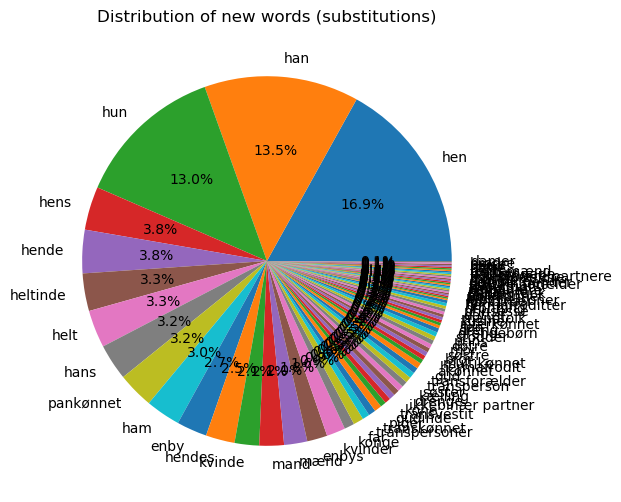

In [9]:
# distribution of new words (substitutions)
c = Counter(new_nouns).most_common() # sorted in descending order
plt.figure(figsize=(6,6))
plt.pie(dict(c).values(), labels=dict(c).keys(), autopct='%1.1f%%')
plt.title("Distribution of new words (substitutions)")
plt.plot();

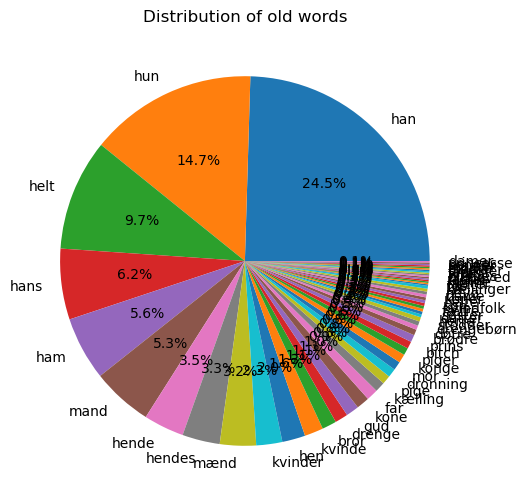

In [12]:
# distribution of old words
c = Counter(old_nouns).most_common() # sorted in descending order
plt.figure(figsize=(6,6))
plt.pie(dict(c).values(), labels=dict(c).keys(), autopct='%1.1f%%')
plt.title("Distribution of old words")
plt.plot();

In [13]:
# which names were replaced?
for k in name_anonymous_dict.keys():
    print(k)

kim
larsen
gu
hr.
lund
va
hej
bjarne
frederik
x.
ole
tøpholms
fuck
polandball
xd
patter
john
faxe
jensen
æhh
vm
trump
løkke
dean
martin
william
erobrens
usa
mary
thomas
vejgaard
fucking
heimdal
130k
ta
över
danmark
lite
snabbt
thors
godwin's
morten
gifv
meg
völdsömt
stödt
övar
räkkefölgan
äf
bögstäver
ï
adolf
hitler
lie
kaas
henrik
hansen
hr
holger
kurt
cobain-sagen
madsen
white
anders
lars
jason
peter
’
s
jesus
christ
theroux's
simon
spies
joakim
dårligt/
niels
stojberg
henriksen
ahlberg
donald
tyfonprins
juel
møn
dronning
margrethe
jakob
krænkelseskulturen
luxembourg
bruno
mars
marius
andersen
noah
trine
bramsens
egon
olsen
andrea
my
country
udspile
ukraine
aserbajdsjan
sidor
hävdar
fuglsang
em'92
mcdonald's
neger
frank
hvam
madsens
brian
saaby
longue
bohr
jørgen
leth
heia
norge
uw
fietsnetwerk
in
naam
van
willem
lene
blabla
vad
charles
vs.
freja
ollegard
gitte
^_______^
paul
mcjones
stroustrup
fogh
æ
bubber
rasmus
amager
tér
hvaøøøh
lassen
victoria
cross
costa
rica
ll
sådan-eller-så

In [14]:
# save the new training set
train_new = pd.DataFrame(zip(new_train_X, y_train_orig), columns=["text", "label"])

# XX pickle
train_new

,text,label
0,hahaha,0
1,@user hvis du føler du har det svært så prøv a...,0
2,det er endnu en barriere for bønder uden for e...,0
3,mit eneste møde ved ham var på min snuskede st...,0
4,forøvrigt taget fra et godt dokumentarprogram ...,0
...,...,...
2626,hørt!,0
2627,min reaktion hvis jeg var svensker,0
2628,hey champ vil du ikke smide et link til hvor d...,0
2629,hvis du melder en for vold eller voldtægt og d...,1


In [19]:
print("Before CDS {}:".format(train_orig.shape))
display(train_orig.head(10))

print("\nAfter CDS {}:".format(train_new.shape))
display(train_new.head(10))

Before CDS (2631, 2):


,tweet,label
id,,
3176,Hahaha,0
1440,@USER hvis du føler du har det svært så prøv a...,0
3501,Det er endnu en barriere for bønder uden for E...,0
3016,Mit eneste møde ved ham var på min snuskede st...,0
2399,Forøvrigt taget fra et godt dokumentarprogram ...,0
3526,Plagiat :') URL,0
2029,###Vi tager vores gamle kongerige tilbage med ...,0
479,@USER Der er altså heller ikk noget værre end ...,0
250,Læs statistikker.. så har du svaret på dit spø...,0



After CDS (2631, 2):


,text,label
0,hahaha,0
1,@user hvis du føler du har det svært så prøv a...,0
2,det er endnu en barriere for bønder uden for e...,0
3,mit eneste møde ved ham var på min snuskede st...,0
4,forøvrigt taget fra et godt dokumentarprogram ...,0
5,plagiat :') url,0
6,###vi tager vores gamle kongerige tilbage med ...,0
7,@user der er altså heller ikk noget værre end ...,0
8,læs statistikker.. så har du svaret på dit spø...,0
9,jeg mener at dfs ideologi har klare nazistiske...,0


In [20]:
# sanity check grammaticality of new sentences
for t in train_new[train_new['label']==1]['text'][:20]:
    print(t)
    print()

her havde jeg scannet lortet ind på pc, markeret og taget hens underskrift over i et nyt dokument og skrevet det på korrekt engelsk. gad vide om hun fik jobbet som vennetjeneste.

du kan klarer den fyr, stort set alle min venner er på vej ud på samme spor, hold kæft hvor føler jeg mig ensom, når alt folk omkring mig vil er at snakke drugs

fuck det, mere sol og varme, mindre regn please. 80% af de danske år er totalt lort, og så snart der kommer lidt sol så begynder alle at whine...

hvorfor i den fucking store helvede skal man fejre kristne helligdage for at blive dansker er danskere ikke vildt ateistiske jeg mener jeg kunne forstå om det var i afrika eller noget ekstremt kristent noget manden lever jo i en boble

der er ingen udlændinge ved grænsen, heller ikke kriminelle. de kan køre lige igennem den symbolske grænsekontrol. hvis man ikke kan komme på sygehuset uden at betale, så er det jo fordi at blå blok, anført af df, har indført brugerbetaling. for sådan går det, når nazister o